In [1]:
import pandas as pd
import itertools
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.text import Text
import textwrap
import matplotlib.patches as mpatches
from matplotlib.path import Path


In [2]:
# variables
path_excel = r'data.xlsx'
sheet_name = 'cactus_data'
file_path = r'images/Figure2 fulllifecycle_cost_comparison_global.pdf'
dpi = 700

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 16


In [3]:
df_all = pd.read_excel(
    path_excel, 
    sheet_name=sheet_name,
)

In [4]:
def getTachsByComponentName(df, name):
    if not name:
        return []
    filter = df.component == name
    print(name)
    print(list(df[filter]['tach']))
    return list(df[filter]['tach'])

In [5]:
def getLifecycleCostsbyCombination(df, container_name, emptying_name, transport_name, treatment_name, label):
    container = getTachsByComponentName(df, container_name)
    transport = getTachsByComponentName(df, transport_name)
    treatment = getTachsByComponentName(df, treatment_name)

    if emptying_name:
        emptying = getTachsByComponentName(df, emptying_name)
        combinations = list(itertools.product(container, emptying, transport, treatment))  
    else:
        combinations = list(itertools.product(container, transport, treatment))   
    sum_array = [round(sum(combination),0) for combination in combinations]  
    sum_array = list(set(sum_array))
    
    if label:
        name = label
    else:
        if emptying_name:
            name = f"{container_name}, {emptying_name}, {transport_name} and {treatment_name}"
        else:
            name = f"{container_name}, {transport_name} and {treatment_name}"
    names = np.full(len(sum_array), name)
    
    result_df = pd.DataFrame({'name': names, 'tach': sum_array})

    return result_df

combinations = [
    [ 
        df_all, 
        'Direct', 
        None, 
        'Pipes - conventional, combined, with pumping', 
        'Passive aerobic waste water',
        'Conventional combined sewers with pumping, passive aerobic wastewater treatment'
    ],
    [ 
        df_all, 
        'Sealed tank with infiltration structure', 
        None, 
        'Wheels - human- and/or machine-powered with transfer station', 
        'Passive aerobic waste water',
        'Sealed tanks with infiltration structure, human/machine powered emptying include transfer station, passive aerobic wastewater treatment'
    ],
    [ 
        df_all, 
        'Infiltrating pit', 
        'Manual (no specialised equipment)', 
        'Wheels - machine-powered (transport only)', 
        'Aerobic FSM',
        'Infiltrating pit, manual emptying, powered transport, aerobic fecal sludge treatment'
    ],
]

dfs = []
for combination in combinations:
    df_original = combination[0]
    container = combination[1]
    emptying = combination[2]
    transport = combination[3]
    treatment = combination[4]
    label = combination[5]
    
    df_combination = getLifecycleCostsbyCombination(df_original, container, emptying, transport, treatment, label)
    
    dfs.append(df_combination)

df = pd.concat(dfs, axis=0)

print(df)
    

Direct
[31.710679666583, 44.6516150860184, 442.156302455009, 108.318212579819, 122.081689078423, 114.752264831068, 178.805968505729, 150.459819294295]
Pipes - conventional, combined, with pumping
[99.3826097582115, 84.7032546700335, 422.987304316186, 470.688410005785, 204.655084207925, 262.534249045979, 341.297725170367]
Passive aerobic waste water
[0.774222508587635, 305.863493024712, 134.785323498589, 24.0418071983282, 318.647451366143, 9.98173079184779, 37.5883559616902, 14.2067339212354, 268.096291634776]
Sealed tank with infiltration structure
[338.058415225574, 140.322312306972, 2139.47431933315, 440.596295497575, 145.903423490436, 158.848629872401, 101.030083248467, 964.176230079835, 222.903135712769, 73.8031374079013]
Wheels - human- and/or machine-powered with transfer station
[101.416643334577]
Passive aerobic waste water
[0.774222508587635, 305.863493024712, 134.785323498589, 24.0418071983282, 318.647451366143, 9.98173079184779, 37.5883559616902, 14.2067339212354, 268.096291

In [6]:
def showLabel(ax, x, y, value):
    ax.text(x, y, f"{value:.0f}", ha='center', va='center', fontsize=14)

['Conventional combined sewers with pumping, passive aerobic wastewater treatment', 'Sealed tanks with infiltration structure, human/machine powered emptying include transfer station, passive aerobic wastewater treatment', 'Infiltrating pit, manual emptying, powered transport, aerobic fecal sludge treatment']


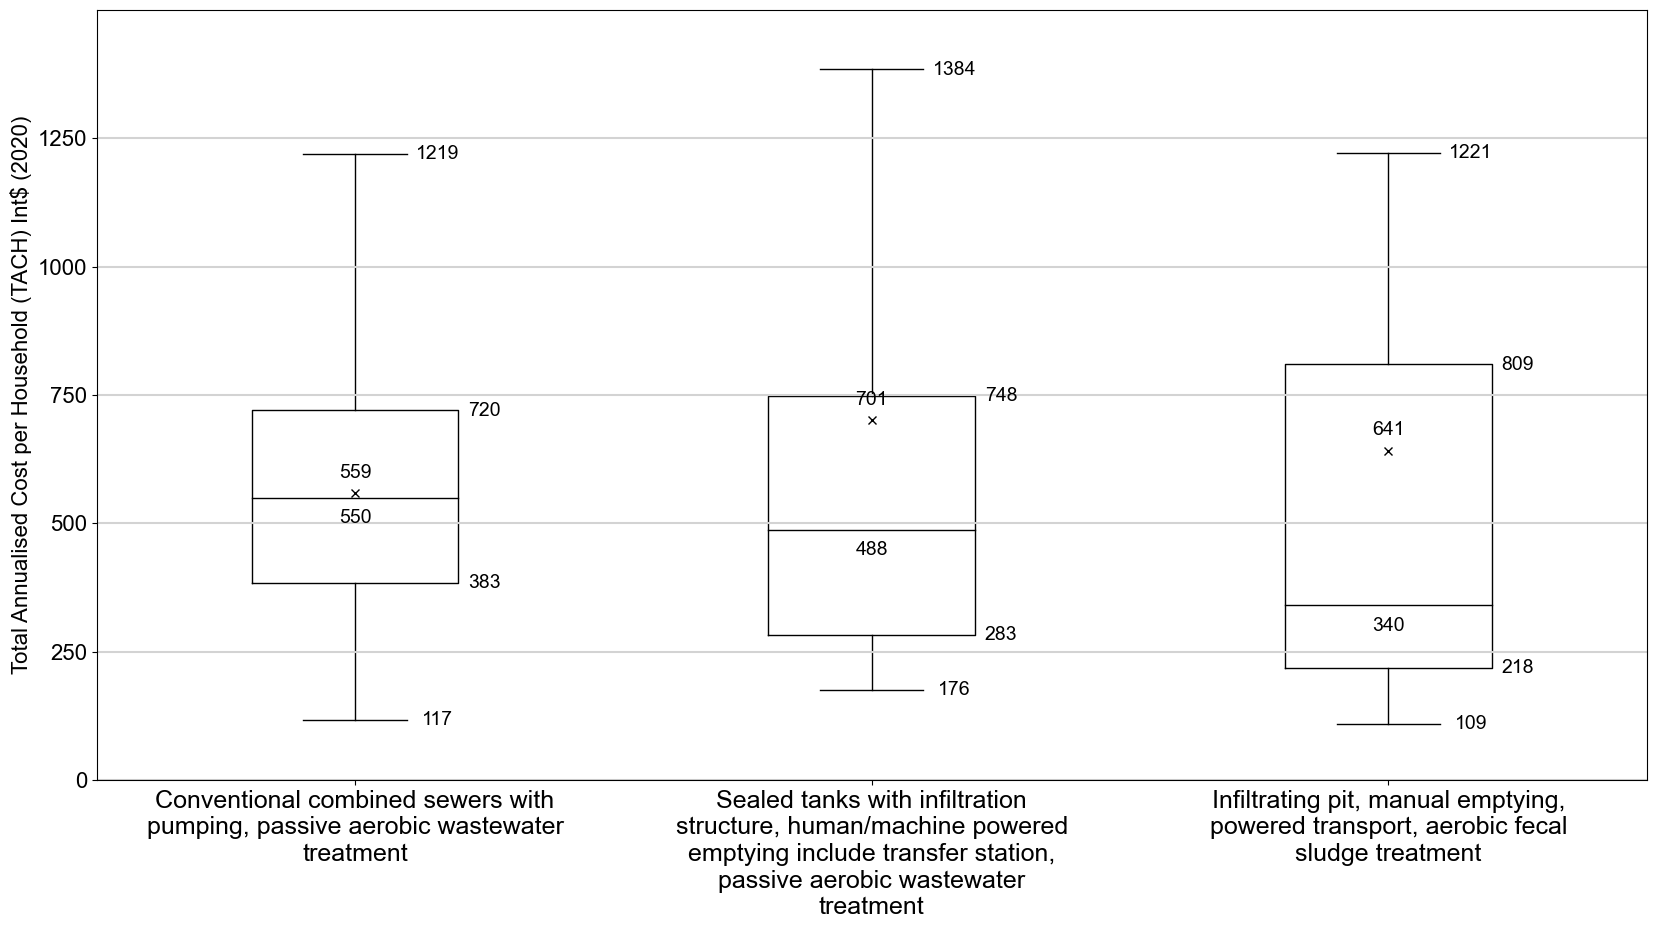

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))

fig.patch.set_facecolor('white') # 背景色を「白」に設定

groups = df.groupby('name', sort=False)
group_labels = list(groups.groups.keys())

print(groups)
print(group_labels)

for j, group in enumerate(groups):
    tach = group[1]['tach']
    size = len(tach)
    position = j + 1

    linestyle = '-'

    if size == 1:
        ax.plot(position, tach, marker='o', color='k', markersize=6)
    else:
        bp = ax.boxplot(
            tach, 
            positions=[position],
            boxprops={'linestyle': linestyle},
            whiskerprops={'linestyle': linestyle},
            showmeans=True, 
            meanprops = {'marker': 'x', 'markerfacecolor': 'k', 'markeredgecolor':'k', 'markersize': 6},
            showfliers = False,
            widths=0.4
        )

        # make median line black
        for median in bp['medians']:
            median.set_color('black')

        med = np.median(tach)
        showLabel(ax, position, med - 40, med)

        mean = np.mean(tach)
        showLabel(ax, position, mean + 40, mean)

        q1, q3 = np.percentile(tach, [25, 75])
        showLabel(ax, position + 0.25, q1, q1)
        showLabel(ax, position + 0.25, q3, q3)

        for i, box in enumerate(bp['boxes']):   
            x_pos = box.get_xdata().mean()

            # get values from boxplot
            cap_min, cap_max = [cap.get_ydata()[1] for cap in bp['caps'][i*2:i*2+2]]
            showLabel(ax, x_pos + 0.2, cap_min, cap_min)
            showLabel(ax, x_pos + 0.2, cap_max, cap_max)

        

ax.set_ylim(0,1500)  
ax.set_yticks(np.arange(0,1500,250))

for ylabel in np.arange(0,1500,250):
    ax.axhline(y=ylabel, color='lightgray')
        
xtick_labels = [ '\n'.join(textwrap.wrap(label, 35)) for label in group_labels ]
ax.set_xticks(np.arange(len(xtick_labels)) + 1)
ax.set_xticklabels(xtick_labels, rotation=0, ha='center', fontsize=18)

ax.set_ylabel('Total Annualised Cost per Household (TACH) Int$ (2020)', fontsize=16)


plt.savefig(file_path, format="pdf", dpi=dpi, transparent=True, bbox_inches='tight')
plt.savefig(f"{file_path}.png", format="png", dpi=dpi, transparent=True, bbox_inches='tight')
plt.show()